# 作业内容
利用随机森林,LR,SVM 解决泰坦尼克号问题

In [405]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble  import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import random
from sklearn.metrics import accuracy_score


In [406]:
train=pd.read_csv("./titanic/train.csv")
test=pd.read_csv("./titanic/test.csv")
# 合并数据集
combine = [train , test]
train.info()  
print("----"*30)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
------------------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          

# 数据字典
<br>
survival	Survival 存活与否	0 = No, 1 = Yes
<br>
pclass	Ticket class 座舱等级	1 = 1st, 2 = 2nd, 3 = 3rd
<br>
sex	gender 性别	
<br>
Age	Age in years 年龄	
<br>
sibsp	# of siblings / spouses aboard the Titanic 船上的兄弟姐妹或配偶个数	
<br>
parch	# of parents / children aboard the Titanic 船上的父母或子女个数	
<br>
ticket	Ticket number 票号	
<br>
fare	Passenger fare 票价	
<br>
cabin	Cabin number 座舱号
<br>
embarked	Port of Embarkation 登船港口	C = Cherbourg 瑟堡, Q = Queenstown 皇后镇, S = Southampton 南安普敦

In [407]:
# 处理数据
for dataset in combine:
    # 根据姓名新增特征
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # 性别特征数字化
    dataset['Sex']=dataset['Sex'].map({'male':1,'female':0}).astype(int)

pd.crosstab(train['Title'], train['Sex'])

Sex,0,1
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [408]:
# 缺省值处理
for dataset in combine:
    #年龄(Age)
    dataset['Age']=dataset['Age'].fillna( dataset['Age'].mean() )
    #船票价格(Fare)
    dataset['Fare'] = dataset['Fare'].fillna( dataset['Fare'].mean() )
    #缺失数据比较多，船舱号（Cabin）缺失值填充为U，表示未知（Uknow） 
    dataset['Cabin'] = dataset['Cabin'].fillna( 'U' )
    #登船港口,使用众数填充
    dataset['Embarked'] = dataset['Embarked'].fillna(dataset.Embarked.dropna().mode()[0])

train.info()  
print("----"*30)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null int32
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null object
Title          891 non-null object
dtypes: float64(2), int32(1), int64(5), object(5)
memory usage: 87.1+ KB
------------------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null int32
Age     

In [409]:
# Name  特征列处理
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don',
                                                 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train[['Title','Survived']].groupby(['Title'],as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [410]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,U,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,3
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,U,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,U,S,1


In [411]:
train = train.drop(['Name', 'PassengerId'], axis=1)
test= test.drop(['Name'], axis=1)
combine = [train, test]
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,0,3,1,22.0,1,0,A/5 21171,7.2500,U,S,1
1,1,1,0,38.0,1,0,PC 17599,71.2833,C85,C,3
2,1,3,0,26.0,0,0,STON/O2. 3101282,7.9250,U,S,2
3,1,1,0,35.0,1,0,113803,53.1000,C123,S,3
4,0,3,1,35.0,0,0,373450,8.0500,U,S,1


In [412]:
# 处理Age特征
train['AgeBand']=pd.cut(train['Age'],5)
train[['AgeBand','Survived']].groupby(['AgeBand'],as_index=False).mean().sort_values(by='AgeBand',ascending=True)

,AgeBand,Survived
0,"(0.34, 16.336]",0.550000
1,"(16.336, 32.252]",0.344168
2,"(32.252, 48.168]",0.404255
3,"(48.168, 64.084]",0.434783
4,"(64.084, 80.0]",0.090909


In [413]:
for dataset in combine:
    dataset.loc[dataset['Age']<=16,'Age']=0
    dataset.loc[(dataset['Age']>16) &(dataset['Age']<=32),'Age']=1
    dataset.loc[(dataset['Age']>32) &(dataset['Age']<=48),'Age']=2
    dataset.loc[(dataset['Age']>48) &(dataset['Age']<=64),'Age']=3
    dataset.loc[(dataset['Age']>64) ,'Age']=4

In [414]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeBand
0,0,3,1,1.0,1,0,A/5 21171,7.2500,U,S,1,"(16.336, 32.252]"
1,1,1,0,2.0,1,0,PC 17599,71.2833,C85,C,3,"(32.252, 48.168]"
2,1,3,0,1.0,0,0,STON/O2. 3101282,7.9250,U,S,2,"(16.336, 32.252]"
3,1,1,0,2.0,1,0,113803,53.1000,C123,S,3,"(32.252, 48.168]"
4,0,3,1,2.0,0,0,373450,8.0500,U,S,1,"(32.252, 48.168]"


In [415]:
train = train.drop(['AgeBand'], axis=1)
combine = [train, test]
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,0,3,1,1.0,1,0,A/5 21171,7.2500,U,S,1
1,1,1,0,2.0,1,0,PC 17599,71.2833,C85,C,3
2,1,3,0,1.0,0,0,STON/O2. 3101282,7.9250,U,S,2
3,1,1,0,2.0,1,0,113803,53.1000,C123,S,3
4,0,3,1,2.0,0,0,373450,8.0500,U,S,1


In [416]:
# 处理SibSp，Parch 特征列
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [417]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [418]:
train = train.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test = test.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train, test]

train.head()

,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,IsAlone
0,0,3,1,1.0,A/5 21171,7.2500,U,S,1,0
1,1,1,0,2.0,PC 17599,71.2833,C85,C,3,0
2,1,3,0,1.0,STON/O2. 3101282,7.9250,U,S,2,1
3,1,1,0,2.0,113803,53.1000,C123,S,3,0
4,0,3,1,2.0,373450,8.0500,U,S,1,1


In [419]:
# 删除无用特征列
train = train.drop(['Ticket', 'Cabin'], axis=1)
test = test.drop(['Ticket', 'Cabin'], axis=1)
combine = [train, test]
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,1,1.0,7.2500,S,1,0
1,1,1,0,2.0,71.2833,C,3,0
2,1,3,0,1.0,7.9250,S,2,1
3,1,1,0,2.0,53.1000,S,3,0
4,0,3,1,2.0,8.0500,S,1,1


In [420]:
# 处理Embarked特征，字符串转数值
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,1,1.0,7.2500,0,1,0
1,1,1,0,2.0,71.2833,1,3,0
2,1,3,0,1.0,7.9250,0,2,1
3,1,1,0,2.0,53.1000,0,3,0
4,0,3,1,2.0,8.0500,0,1,1


In [421]:
# 处理Fare船价特征
train['FareBand'] = pd.qcut(train['Fare'], 4)
train[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [422]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train= train.drop(['FareBand'], axis=1)
combine = [train, test]
    
train.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,1,1.0,0,0,1,0
1,1,1,0,2.0,3,1,3,0
2,1,3,0,1.0,1,0,2,1
3,1,1,0,2.0,3,0,3,0
4,0,3,1,2.0,1,0,1,1
5,0,3,1,1.0,1,2,1,1
6,0,1,1,3.0,3,0,1,1
7,0,3,1,0.0,2,0,4,0
8,1,3,0,1.0,1,0,3,0
9,1,2,0,0.0,2,1,3,0


In [423]:
test.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,892,3,1,2.0,0,2,1,1
1,893,3,0,2.0,0,0,3,0
2,894,2,1,3.0,1,2,1,1
3,895,3,1,1.0,1,0,1,1
4,896,3,0,1.0,1,0,3,0


In [424]:
X_train = train.drop("Survived", axis=1)
Y_train = train["Survived"]
X_test  = test.drop("PassengerId", axis=1).copy()
train.sample(20)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
578,0,3,0,1.0,2,1,3,0
194,1,1,0,2.0,2,1,3,1
37,0,3,1,1.0,1,0,1,1
798,0,3,1,1.0,0,1,1,1
452,0,1,1,1.0,2,1,1,1
187,1,1,1,2.0,2,0,1,1
716,1,1,0,2.0,3,1,2,1
547,1,2,1,1.0,1,1,1,1
560,0,3,1,1.0,0,2,1,1
159,0,3,1,1.0,3,0,4,0


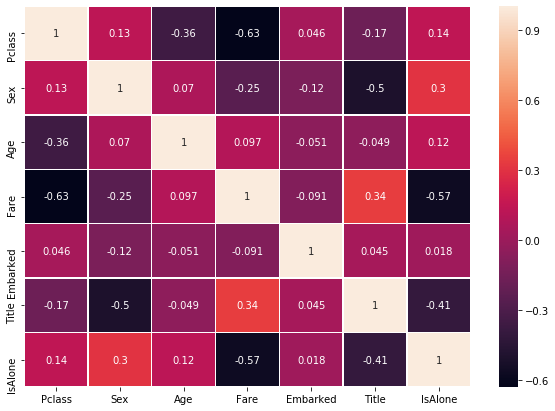

In [425]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(10, 7),sharex=True)
sns.heatmap(X_train.corr(), annot=True, linewidths=.5, ax=axes)

In [426]:
# 从热力图可以看出，特征之间的相关性并不高，这说明这些模型特征可以很好的独立表示数据


In [427]:
from sklearn.model_selection import KFold
X_train, X_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
kf = KFold(n_splits=5,shuffle=True,random_state=0)
cls=[ 
    ('svc', SVC()),
    ('rfc', RandomForestClassifier(n_estimators=100)),
    ('lr', LogisticRegression()),
    ]
best_score=0
best_clf=''
for clf in cls:

    curr_score=0
    for train_index,valid_index in kf.split(X_train):
        #拟合数据
        clf[1].fit(X_train.iloc[train_index],y_train.iloc[train_index])
        # 使用测试数据验证模型
        curr_score=curr_score+clf[1].score(X_train.iloc[valid_index],y_train.iloc[valid_index])
    avg_score=curr_score/5
    if avg_score>best_score:
        best_score=avg_score
        best_clf=clf[0]
    # 获得测试集准确率
    test_score=clf[1].score(X_test,y_test)
    print("模型",clf[0],"训练集的准确率:",avg_score," 训练集的准确率:",test_score)


D:\Program Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Program Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Program Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\Program Files\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: Fut

模型 svc 训练集的准确率: 0.8202600216684723  训练集的准确率: 0.7877094972067039
模型 rfc 训练集的准确率: 0.8174529695656456  训练集的准确率: 0.7932960893854749
模型 lr 训练集的准确率: 0.807593814636068  训练集的准确率: 0.7821229050279329


D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Program Files\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to

In [428]:
sub = pd.DataFrame()

sub['PassengerId'] = test['PassengerId']
sub['Survived'] =cls[1][1].predict(X_test)
sub.to_csv('submit.csv', index=False)

ValueError: Length of values does not match length of index

In [433]:
test.head()
len(X_test)

179

In [ ]:
cls[1][1]